# GRAD-CAM

- Paper: https://arxiv.org/pdf/1610.02391.pdf
- Keras implementation with explanation: https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-gradcam-554a85dd4e48
- Tensorflow 2.0 implementation: https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
- Torch code for Grad-CAM (original implementation):https://github.com/ramprs/grad-cam/

Grad-CAM is a technique for visual explanations of predictions made by CNN. It is based on idea of linear approximation of function with gradients. 

### Imports

In [2]:
import os
import sys
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import imageio
from datetime import datetime

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
import tensorflow as tf
from keras.models import load_model, Model
from keras import backend as K

### load the model

In [6]:
model_path = "weights/vgg16_transfer_weights.h5"

In [7]:
model = load_model(model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### load data

In [8]:
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg


In [9]:
def resize(arr, input_size):
    return np.array(Image.fromarray(arr).resize(input_size, resample=1))

In [10]:
def resize_and_preprocess(img, input_size=None, preprocessing_function=None):
    if input_size:
        try:
            img = resize(img, input_size[:2])
        except Exception as err:
            img = None
            print("[ERROR] Failed resizing image ")
            print(err)
    if preprocessing_function:
        try:
            img = preprocessing_function(img)
        except Exception as err:
            img = None
            print("[ERROR] Failed applying preprocessing function to image")
            print(err)
    return img

In [80]:
#img_path = "data/training_folder/test/07/image_0517.jpg"
#img_path = "data/training_folder/test/07/image_0500.jpg"
#img_path = "data/training_folder/test/15/image_1126.jpg"
img_path = "data/training_folder/test/02/image_0143.jpg"

In [81]:
img = cv2.imread(img_path)

In [82]:
img_vgg = resize_and_preprocess(img,
                                input_size=(224, 224, 3),
                                preprocessing_function=preprocess_input_vgg)

In [83]:
img_data = np.expand_dims(img_vgg, 0)

In [84]:
img_data.shape

(1, 224, 224, 3)

In [85]:
pred = model.predict(img_data)

In [86]:
classes = ["{:02d}".format(i) for i in range(1, 18)]
pred_class_idx = np.argmax(pred, axis=1)[0]
classes[pred_class_idx]

'02'

In [89]:
pred

array([[0.09184891, 0.23470365, 0.06697047, 0.08857378, 0.03169194,
        0.0160112 , 0.08371491, 0.20698412, 0.01200167, 0.01443295,
        0.03515111, 0.01529259, 0.01042223, 0.04668987, 0.02662036,
        0.01629774, 0.00259248]], dtype=float32)

In [90]:
#model.summary()

### Grad-CAM

In [91]:
from matplotlib import pyplot as plt
%matplotlib inline

from datetime import datetime

In [92]:
nb_classes = int(model.output.shape[-1])

In [93]:
t0 = datetime.now()

last_conv = model.get_layer('block5_conv3')
#grads = K.gradients(model.output[:,0],last_conv.output)[0]
grads = {i:K.gradients(model.output[:,i],last_conv.output)[0] for i in range(nb_classes)}

In [94]:
pooled_grads = {i:K.mean(grads[i],axis=(0,1,2)) for i in range(nb_classes)}
iterate = {i:K.function([model.input],[pooled_grads[i],last_conv.output[0]]) for i in range(nb_classes)}

In [95]:
t0 = datetime.now()
pooled_grads_value,conv_layer_output = iterate[pred_class_idx]([img_data])

In [96]:
heatmap = np.dot(conv_layer_output, pooled_grads_value)/512

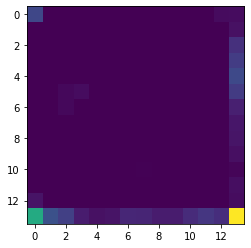

In [97]:
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)

We'll resize heatmap to original image size 

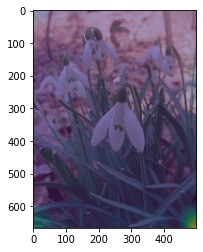

In [98]:
img_rgb = img[:,:,::-1]
upsample_heatmap = resize(heatmap, input_size = img.shape[:2][::-1])
plt.imshow(img_rgb)
plt.imshow(upsample_heatmap,alpha=0.5)
plt.show()